# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor

# import

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/populationbycity/PopulatinandArea.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [168]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [169]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [170]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

#загрузим свой датасет с городами и численностью
population = pd.read_csv('/kaggle/input/populationbycity/PopulatinandArea.csv', delimiter=';')

In [171]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [172]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [173]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [174]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [175]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [176]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [177]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

## Предподготовка. Ниже будут нужные функции(если потребуются)

In [179]:
#функция для создания boxPlot по набору колонок
def get_boxplot(column):
    #на вход наименование колоноки, в ответе боКсплоты
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='Rating', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

## "Чистим" данные

Посмотрим что по пропускам

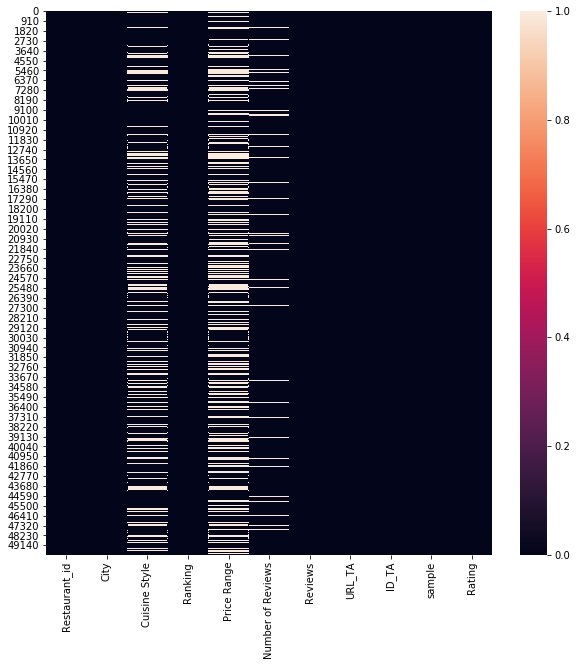

In [180]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.isnull(), ax=ax)

Много пропусках в: кухнях, диапазоне цен и кол-ве обзоров.
Важный момент, который не виден на графике, есть Nan в отзывах, хотя на графике это не видно, на предыдущих шагах можно заметить 2 пустых отзыва.

Первое будем использовать как отдельный признак и тк переменную потом удалять, ничего не будем указывать.
Цену в ресторане проставим модой.
А кол-во ревью укажем более гибко тк надо проверить если ли текст ревью сперва для таких случаев на сайте. Поэтому заполним эти пропуски во время генерации новых фич

In [181]:
def fill_Na_Price_Range():
#укажем самое популярное значение цены в случаях если цены нет
    data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)
#ps была идея считать популярную цену по городу, но везде это "средний ценовой сегмент"

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [182]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

Города, стили кухни, диапазон цен можно выделить в отдельные признаки + создадим свои на основе того что уже есть

Есть даты, попробуем создать признак с разницей в днях между отзывами на сайте.

In [183]:
#сперва заполним два пропуска в отзывах, которые не дадут дальнейшую работу сделать
data['Reviews'].fillna('[[], []]', inplace=True)

#нашли нужную строку по патерну, добавили в новую ячейку, потом ещё две ячейки заполнили обратившись по индексу 
pattern = re.compile('\'\d+\/\d+\/\d+\'?')
dates = data['Reviews'].apply(pattern.findall)
data['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
data['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))

#Теперь создаём новый столбец Delta с разницей в днях между отзывами
data['delta']= (data['date1'] - data['date2']).dt.days

In [184]:
#Так же добавим признак с разницей в днях между нашими отзывами и средними "по больнице"
dlt = data['delta'].mean()
data['mean_delta'] = dlt - data['delta']

Теперь тк есть данные о днях когда были отзывы, мы упростили себе задачу по заполнению случаев, когда кол-во отзывов не указано но отзывы есть. Достаточно простое заполнение без "изюминки".

In [185]:
#смотрим если нет данных о кол-во ревью и первая дата пустая, значит ноль
data.loc[((data['Number of Reviews'].isna()) & (data['date1'].isna())), 'Number of Reviews'] = 0
#сморим если нет данных о кол-во ревью и вторая дата пустая, значит 1 обзор
data.loc[((data['Number of Reviews'].isna()) & (data['date1'].isna()==False) & (data['date2'].isna())), 'Number of Reviews'] = 1
#во всех остальных случаях среднее кол-во обзоров по городу(может стоило город+ценовой диапазон или тип кухни взять)
data['Number of Reviews'] = data.groupby('City').transform(lambda x: x.fillna(x.mean()))['Number of Reviews']

Теперь создадим средний и макс.рейтинг ресторана по городу

In [186]:
#Укажем так же средний и макс. рейтинг ресторана в городе где он находится
meanRanking = data.groupby(['City'])['Ranking'].agg(['mean', 'max']) #создаём новый ДФ
meanRanking = meanRanking.rename(columns={'mean': 'meanByCity', 'max': 'maxByCity'}) 
merged = meanRanking.merge(data, on='City', how='inner') #соединяем с нашим

Думаю что важный признак - сколько всего ресторанов в городе

In [187]:
#Укажем сколько всего ресторанов в городе
TotalRestaurantInCity = data.groupby(['City'])['Restaurant_id'].agg(['count'])
TotalRestaurantInCity = TotalRestaurantInCity.rename(columns={'count': 'TotalRestaurantInCity'})
data = TotalRestaurantInCity.merge(merged, on='City', how='inner')

Загрузил ДФ с городами и населением, используем его для того чтобы узнать какое население на один ресторан в городе и сколько всего людей на город

In [188]:
#присоединим данные о городе и создадим доп.переменную о кол-ве человек на ресторан
data = data.merge(population, on='City', how='left') #через left если в списке городов не будет подходящего
data['PopulationPerRestaurant'] = data['Population']/data['TotalRestaurantInCity']

Займёмся кухнями:
1. Добавим dummy-переменные по кухням(*кажется что можно было сделать проще*)
2. и Кол-во представленных кухнь в ресторане

In [189]:
data['Cuisine Style'].fillna("['NoCusine']", inplace=True)


In [190]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x)) #волшебный eval()
CuisineCnt = data['Cuisine Style'].explode().value_counts() #список значений чтобы отобрать ТОП 90 всех ресторанов по кухням
allCuisines = data['Cuisine Style'].explode().value_counts() #непосредственно кухни
percentile = (int(np.percentile(CuisineCnt, 20))) #20й персентиль 
topCuisines = list(allCuisines[allCuisines>percentile].index) # отсекаем только 80% нужных нам значений

#подсмотренное решение через for и lambda
#создаем столбцы для каждой кухни, записываем 1 - если кухня есть в соответствующей ячейке, 0 - если нет
for cuisine in topCuisines:
    data[cuisine] = data['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0)

#Добавим ещё Кол-во кухонь в ресторане. новое поле Cuisine_cnt
#Убираем всё лишнее из столбца-перечня кухонь, потом считаем длину массива и проставляем в Cuisine_cnt
data['CuisineСnt']= data['Cuisine Style'].apply(lambda x: len(x))

1. По ценам
2. По городам. *Хотел создать по ТОП городов, но MAE проседает, поэтому использую все города*

In [191]:
data['Price Range_NAN'] = data['Price Range'].isna()
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

price_dict = {'$': 1,
              '$$ - $$$': 2,
              '$$$$': 3}

data['Price Range'] = data['Price Range'].map(price_dict)

In [192]:
#dummy-переменные по городам
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

# EDA

### Посмотрим распределение признака

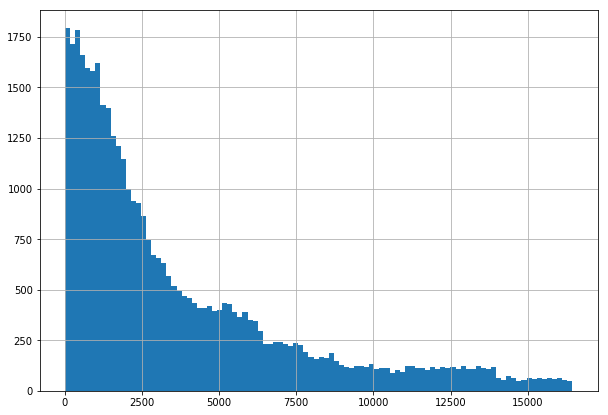

In [193]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

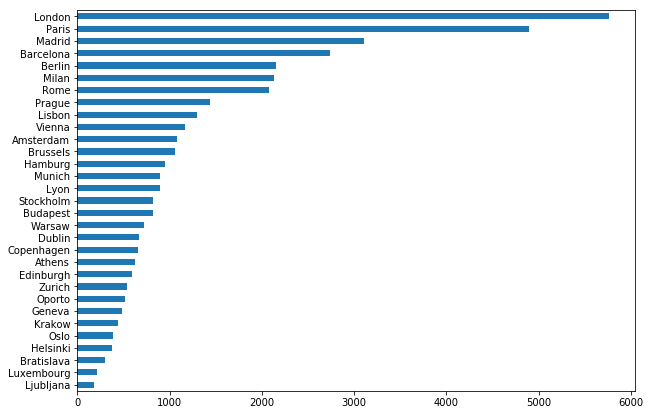

In [194]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) 
> позже узнаем что у Французов больше всего ресторанов на человека

Посмотрим, как изменится распределение в большом городе:

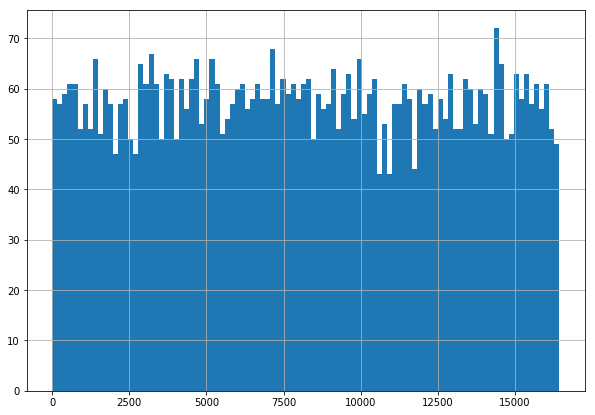

In [195]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

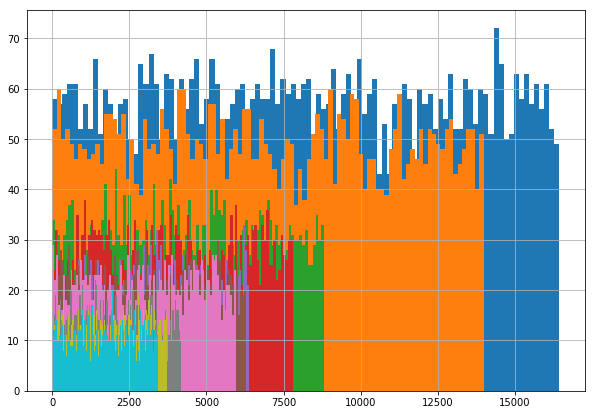

In [196]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [197]:
#Выше был график-подсказка. На основе того что видим нормируем ranking
#тк для маленьких городов больше шансов получить больший Ranking
data['ranking_norm'] = data['Ranking'] / data['TotalRestaurantInCity']

И сразу удалим Ranking

In [198]:
del data['Ranking']

### Посмотрим распределение целевой переменной

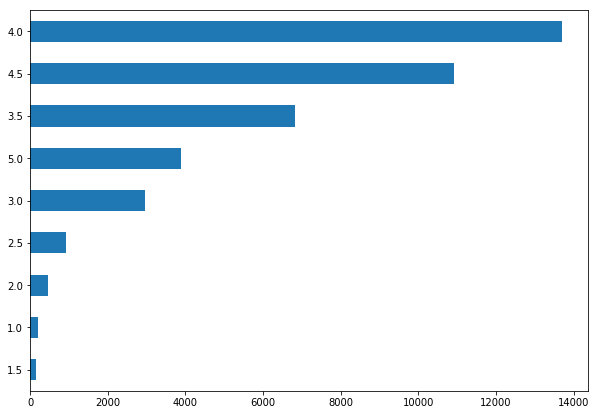

In [199]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

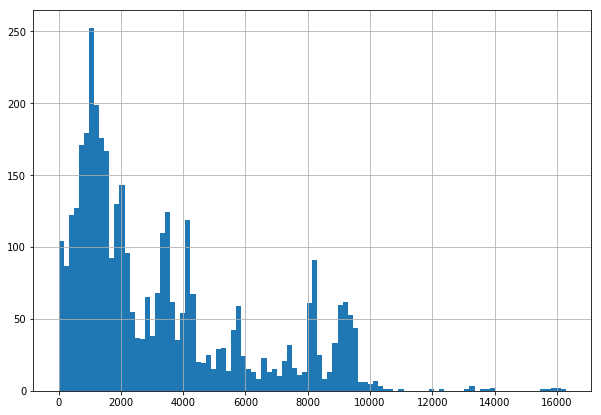

In [200]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

Вот этот хвост в конце можно было бы и удалить. Многие рестораны имеют 5* хотя находятся на 16 000 месте?

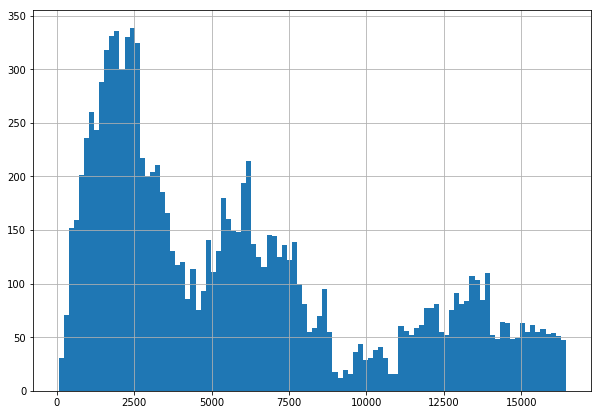

In [201]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

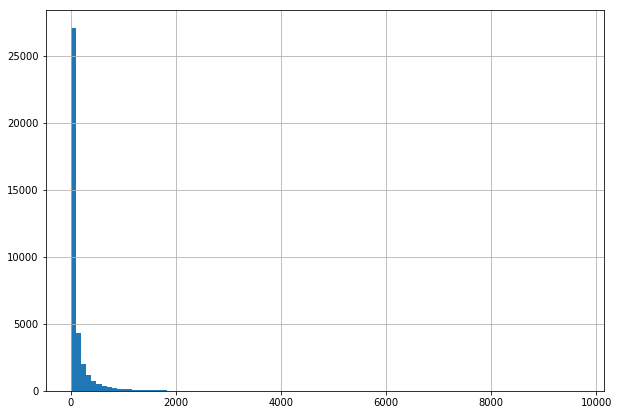

In [202]:
df_train['Number of Reviews'].hist(bins=100)

На графике выше смущает длинющий хвост до 10к.

In [203]:
df_train.sort_values(by='Number of Reviews', ascending=False).head()
#выглядит правдоподобно

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample
19251,id_375,London,"['British', 'Vegetarian Friendly', 'Gluten Fre...",376.0,4.0,$$$$,9660.0,"[['Lovely setting and decent food', 'A Christm...",/Restaurant_Review-g186338-d1421189-Reviews-Lo...,d1421189,1
27027,id_64,Rome,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",65.0,4.5,$$ - $$$,8927.0,"[['Best Service !!!!', 'Simply amazing!'], ['0...",/Restaurant_Review-g187791-d2094750-Reviews-Ca...,d2094750,1
15779,id_430,Paris,"['French', 'European', 'Contemporary', 'Vegeta...",431.0,4.0,$$$$,7622.0,"[['This night is not about the meal, it is ab....",/Restaurant_Review-g187147-d736855-Reviews-58_...,d736855,1
16433,id_12,Budapest,"['Hungarian', 'Vegetarian Friendly', 'Vegan Op...",13.0,4.5,$$ - $$$,7575.0,"[['Traditional food, all local and great', 'Co...",/Restaurant_Review-g274887-d3351231-Reviews-Hu...,d3351231,1
8516,id_266,Amsterdam,"['Barbecue', 'American', 'Vegetarian Friendly'...",267.0,4.0,$$ - $$$,6777.0,"[['Love ! Food and cocktails amazing!', 'As al...",/Restaurant_Review-g188590-d1010937-Reviews-Ha...,d1010937,1


### Что по корреляции?

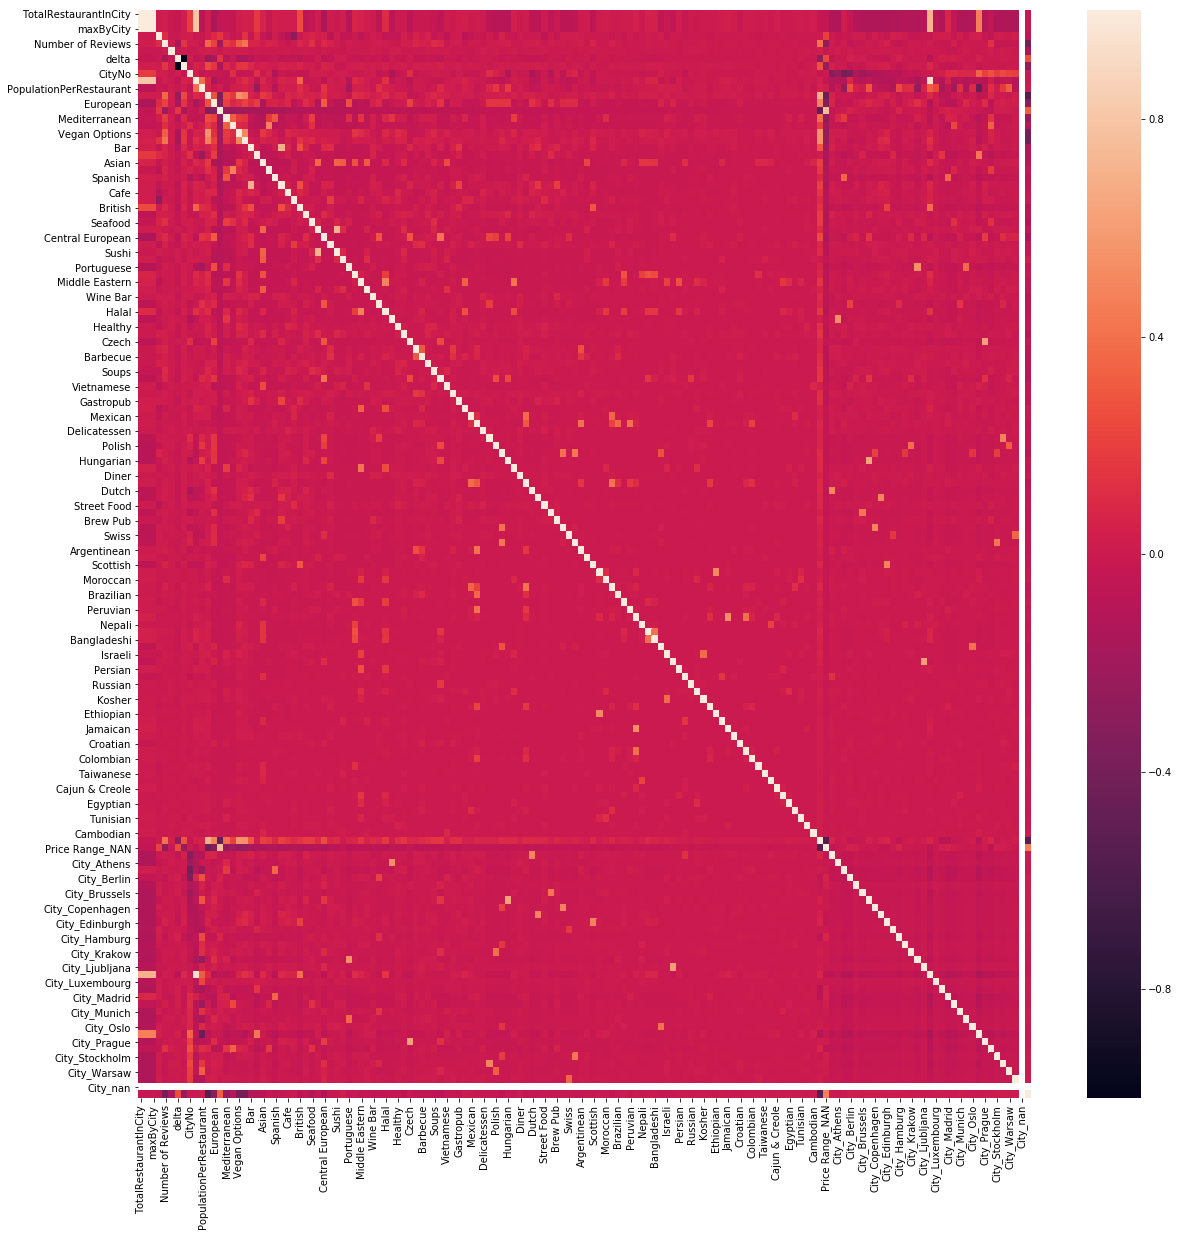

In [204]:
plt.rcParams['figure.figsize'] = (20,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Посмотрим всё тоже самое но цифрами.

In [205]:
corr_fields = data.corr().stack() #Получаем таблицу корреляций
corr_fields.name = 'Most Correlation fields' #дадим название
corr_fields.index.names = ['Col1', 'Col2'] #и переименуем для красоты
corr_fields[(corr_fields != 1.0)&((corr_fields > 0.3)|(corr_fields < -0.3))].to_frame() #отфильтруем явные корреляции поля самому к себе
# и ставим фильтр на + 0.3 чтобы посмотреть по больше того что есть в данных

Most Correlation fields
Col1                  Col2                                        
TotalRestaurantInCity meanByCity                          0.999881
                      maxByCity                           0.999949
                      Population                          0.802042
                      City_London                         0.705578
                      City_Paris                          0.467773
...                                                            ...
ranking_norm          NoCusine                            0.328093
                      Vegan Options                      -0.389868
                      Gluten Free Options                -0.408048
                      CuisineСnt                         -0.543255
                      Price Range_NAN                     0.467034

[202 rows x 1 columns]

Видим огромную корреляцию TotalRestaurantInCity к meanByCity и maxByCity на уровне 0.999881 и 0.999949 соответственно. Такие признаки можно сразу удалять не создавать во время обработки данных, они мусорные для нас.

In [206]:
del data['meanByCity']
del data['maxByCity']

Отдельно посмотрим корреляции к рейтингу с двух сторон.

In [207]:
display(data.corr().Rating.sort_values(ascending=False).to_frame().head(5))
display(data.corr().Rating.sort_values(ascending=True).to_frame().head(5))

,Rating
Rating,1.000000
sample,0.936543
Vegetarian Friendly,0.037317
CuisineСnt,0.034506
Vegan Options,0.029015


,Rating
ranking_norm,-0.168728
City_Milan,-0.023233
delta,-0.022166
Chinese,-0.021039
Price Range_NAN,-0.020519


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [208]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [209]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['ID_TA', 'URL_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    #сперва заполним два пропуска в отзывах, которые не дадут дальнейшую работу сделать
    df_output['Reviews'].fillna('[[], []]', inplace=True)
  
    # ################### 4. Feature Engineering ####################################################
    #нашли нужную строку по патерну, добавили в новую ячейку, потом ещё две ячейки заполнили обратившись по индексу 
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    dates = df_output['Reviews'].apply(pattern.findall)
    df_output['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
    df_output['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))

    #Теперь создаём новый столбец Delta с разницей в днях между отзывами
    df_output['delta']= (df_output['date1'] - df_output['date2']).dt.days

    #если где-то ноли в delta, заполним их
    df_output['delta'].fillna(0, inplace=True)

    #Так же добавим признак с разницей в днях между нашими отзывами и средними "по больнице"
    dlt = df_output['delta'].mean()
    df_output['mean_delta'] = dlt - df_output['delta']

    #смотрим если нет данных о кол-во ревью и первая дата пустая, значит ноль
    df_output.loc[((df_output['Number of Reviews'].isna()) & (df_output['date1'].isna())), 'Number of Reviews'] = 0
    #сморим если нет данных о кол-во ревью и вторая дата пустая, значит 1 обзор
    df_output.loc[((df_output['Number of Reviews'].isna()) & (df_output['date1'].isna()==False) & (df_output['date2'].isna())), 'Number of Reviews'] = 1
    #во всех остальных случаях среднее кол-во обзоров по городу(может стоило город+ценовой диапазон или тип кухни взять)
    df_output['Number of Reviews'] = df_output.groupby('City').transform(lambda x: x.fillna(x.mean()))['Number of Reviews']

    #Укажем так же средний и макс. рейтинг ресторана в городе где он находится
    meanRanking = df_output.groupby(['City'])['Ranking'].agg(['mean', 'max']) #создаём новый ДФ
    meanRanking = meanRanking.rename(columns={'mean': 'meanByCity', 'max': 'maxByCity'}) 
    merged = meanRanking.merge(df_output, on='City', how='inner') #соединяем с нашим

    #Укажем сколько всего ресторанов в городе
    TotalRestaurantInCity = df_output.groupby(['City'])['Restaurant_id'].agg(['count'])
    TotalRestaurantInCity = TotalRestaurantInCity.rename(columns={'count': 'TotalRestaurantInCity'})
    df_output = TotalRestaurantInCity.merge(merged, on='City', how='inner')    
    
    #нормируем ranking
    df_output['ranking_norm'] = df_output['Ranking'] / df_output['TotalRestaurantInCity']
    
    #присоединим данные о городе и создадим доп.переменную о кол-ве человек на ресторан
    df_output = df_output.merge(population, on='City', how='left') #через left если в списке городов не будет подходящего
    df_output['PopulationPerRestaurant'] = df_output['Population']/df_output['TotalRestaurantInCity']

    #Добавим dummy-переменные по кухням(только популярным)
    df_output['Cuisine Style'].fillna("['NoCusine']", inplace=True)

    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: eval(x)) #волшебный eval()
    CuisineCnt = df_output['Cuisine Style'].explode().value_counts() #список значений чтобы отобрать ТОП 90 всех ресторанов по кухням
    allCuisines = df_output['Cuisine Style'].explode().value_counts() #непосредственно кухни
    percentile = (int(np.percentile(CuisineCnt, 20))) #20й персентиль 
    topCuisines = list(allCuisines[allCuisines>percentile].index) # отсекаем только 80% нужных нам значений

    #подсмотренное решение через for и lambda
    #создаем столбцы для каждой кухни, записываем 1 - если кухня есть в соответствующей ячейке, 0 - если нет
    for cuisine in topCuisines:
        df_output[cuisine] = df_output['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0)

    #Добавим ещё Кол-во кухонь в ресторане. новое поле Cuisine_cnt
    #Убираем всё лишнее из столбца-перечня кухонь, потом считаем длину массива и проставляем в Cuisine_cnt
    df_output['CuisineСnt']= df_output['Cuisine Style'].apply(lambda x: len(x))
  
    #Пустые цены - отдельный столбец
    df_output['Price Range_NAN'] = df_output['Price Range'].isna()
    
    #Проставим цены где их нет и укажем значения 1-2-3
    df_output['Price Range'].fillna(df_output['Price Range'].mode()[0], inplace=True)
    price_dict = {'$': 1, '$$ - $$$': 2,'$$$$': 3}
    df_output['Price Range'] = df_output['Price Range'].map(price_dict)

    #dummy-переменные по городам
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)

    # ################### 5. Clean #################################################### 
    #Удаляем сильно скоррелированные столбцы и уже лишний Ranking
    del df_output['meanByCity']
    del df_output['maxByCity']
    del df_output['Ranking']
    
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    #Убираем признаки date
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == '<M8[ns]']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [210]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,TotalRestaurantInCity,Price Range,Number of Reviews,sample,Rating,delta,mean_delta,ranking_norm,CityNo,Population,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
14785,1186,2,23.0,1,4.0,2.0,88.32006,0.856661,12,1822445,...,0,0,0,0,0,0,0,0,0,0
3706,3395,2,11.0,1,4.0,763.0,-672.67994,1.602946,4,1620809,...,0,0,0,0,0,0,0,0,0,0
14724,1186,2,12.0,1,3.5,0.0,90.32006,1.534570,12,1822445,...,0,0,0,0,0,0,0,0,0,0
25481,263,2,203.0,1,4.5,2.0,88.32006,0.121673,18,590667,...,0,0,0,0,0,0,0,0,0,0
31896,2694,2,42.0,1,4.0,117.0,-26.67994,0.775056,21,1370074,...,0,0,0,0,0,0,0,0,0,0
39838,6108,2,4.0,1,4.0,0.0,90.32006,1.622626,25,2206488,...,0,0,1,0,0,0,0,0,0,0
25372,263,2,2.0,1,3.5,0.0,90.32006,2.026616,18,590667,...,0,0,0,0,0,0,0,0,0,0
21656,7193,2,1.0,1,5.0,0.0,90.32006,1.259558,17,8825000,...,0,0,0,0,0,0,0,0,0,0
48802,925,2,12.0,1,5.0,88.0,2.32006,0.490811,30,1764615,...,0,0,0,0,0,0,0,1,0,0
12577,836,2,137.0,1,3.0,51.0,39.32006,1.881579,9,527612,...,0,0,0,0,0,0,0,0,0,0


In [211]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 145 entries, TotalRestaurantInCity to City_nan
dtypes: bool(1), float64(6), int64(106), uint8(32)
memory usage: 44.7 MB


In [212]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [213]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [214]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 144), (40000, 144), (40000, 143), (32000, 143), (8000, 143))

# Model 
Сам ML

In [215]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [216]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [217]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [218]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20442375


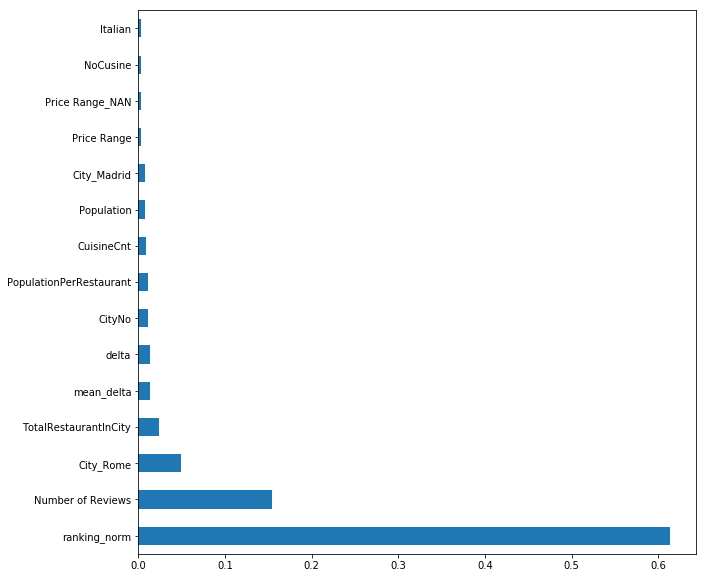

In [219]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [220]:
test_data.sample(10)

,TotalRestaurantInCity,Price Range,Number of Reviews,Rating,delta,mean_delta,ranking_norm,CityNo,Population,PopulationPerRestaurant,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
49386,685,2,56.0,0.0,3.0,87.32006,1.310949,31,409241,597.432117,...,0,0,0,0,0,0,0,0,1,0
18463,7193,2,224.0,0.0,11.0,79.32006,0.283887,17,8825000,1226.887251,...,0,0,0,0,0,0,0,0,0,0
30503,2694,1,8.0,0.0,0.0,90.32006,1.312918,21,1370074,508.564959,...,0,0,0,0,0,0,0,0,0,0
5610,2705,1,17.0,0.0,30.0,60.32006,0.672458,4,3711930,1372.247689,...,0,0,0,0,0,0,0,0,0,0
18967,7193,1,18.0,0.0,118.0,-27.67994,1.165300,17,8825000,1226.887251,...,0,0,0,0,0,0,0,0,0,0
47003,1443,2,359.0,0.0,8.0,82.32006,0.286209,29,1889083,1309.135828,...,0,0,0,0,0,0,1,0,0,0
16504,1647,2,57.0,0.0,536.0,-445.67994,0.612022,15,504718,306.446873,...,0,0,0,0,0,0,0,0,0,0
49461,685,2,4.0,0.0,68.0,22.32006,2.039416,31,409241,597.432117,...,0,0,0,0,0,0,0,0,1,0
43649,2589,2,614.0,0.0,502.0,-411.67994,0.886056,27,2868782,1108.065662,...,0,0,0,0,1,0,0,0,0,0
16231,1647,2,13.0,0.0,-60.0,150.32006,1.719490,15,504718,306.446873,...,0,0,0,0,0,0,0,0,0,0


In [221]:
test_data = test_data.drop(['Rating'], axis=1)

In [222]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [223]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [224]:
predict_submission

array([4.415, 4.355, 4.42 , ..., 4.43 , 2.62 , 3.61 ])

In [225]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,4.415
1,id_1,4.355
2,id_2,4.420
3,id_3,3.950
4,id_4,3.695
5,id_5,3.985
6,id_6,3.830
7,id_7,3.915
8,id_8,3.710
9,id_9,3.885
